In [627]:
#k最近傍法（2018年12月〜2019年6月中旬までの糖度を予測）

In [691]:
%matplotlib inline
import sys
sys.path.append('/home/yoshida/.pyenv/versions/3.6.6/lib/python3.6/site-packages')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [692]:
# データの読み込み
data = pd.read_csv("../src/Aiko_normalization_ver3_aaa.csv")
df = pd.DataFrame(data)

In [693]:
df.drop(['No','width','height','seed_date','house','url', 'COL_21'], axis=1, inplace=True) #対象の列を削除

In [694]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 14 columns):
current_date      2176 non-null object
sweet             2176 non-null float64
sweet_category    2176 non-null int64
size              2176 non-null float64
AveCO2_7          2176 non-null float64
AveSatu_7         2176 non-null float64
AveHum_7          2176 non-null float64
AveTemp_7         2176 non-null float64
AveMaxTemp_7      2176 non-null float64
AveMinTemp_7      2176 non-null float64
AveDiffTemp_7     2176 non-null float64
SumMaxTemp_7      2176 non-null float64
SumMinTemp_7      2176 non-null float64
SumDiffTemp_7     2176 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 238.1+ KB


In [695]:
# AveDiffTemp_7、AveSatu_7、monthを対象としたい時
#df.drop(['AveCO2_7', 'AveSatu_7', 'AveTemp_7', 'AveHum_7', 'AveMinTemp_7', 'AveDiffTemp_7', 'SumMaxTemp_7','SumMinTemp_7','SumDiffTemp_7'], axis=1, inplace=True)

In [696]:
df.head()

,current_date,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
0,11月28日,4.3,2,7.54,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
1,11月28日,4.5,2,6.48,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
2,11月28日,4.0,1,8.68,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
3,11月28日,3.5,1,10.50,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
4,11月28日,4.3,2,7.00,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9


In [697]:
# 'AveCO2_7', 'AveSatu_7', 'AveHum_7', 'AveTemp_7', 'AveMaxTemp_7', 'AveMinTemp_7','AveDiffTemp_7','SumMaxTemp_7','SumMinTemp_7','SumDiffTemp_7'

In [698]:
df['month'] = df['current_date'].str[:2] # "11月28日"とか"4月3日"の月日の先頭2文字だけ抽出
df['month'] = df['month'].str.strip('月') # このままだと"4月"のように"月"が入っているので、"月"を削除する
# 参考：https://deepage.net/features/pandas-str-extract.html
# 参考：https://deepage.net/features/pandas-str-replace.html
df['month'].isnull().sum() # 欠損値がないかを確認

df.drop(['current_date'], axis=1, inplace=True) # current_dateはもう使わない
print(df.shape)

(2176, 14)


In [699]:
# 四半期を求める(4~6月:1st、7~9月:2nd、10~12月:3rd、1~3月:4th)(＊＊＊＊使うか使わないか＊＊＊＊)
df['quarter'] = df['month'].replace({'4': '1st', '5': '1st', '6': '1st', 
                                     '7': '2nd', '8': '2nd', '9': '2nd', 
                                     '10': '3rd', '11': '3rd', '12': '3rd', 
                                     '1': '4th', '2': '4th', '3': '4th'
                                    })

In [700]:
# ダミー変数の作成
df = pd.get_dummies(df, columns=['quarter'], drop_first=True)

In [701]:
df.drop(['month'], axis=1, inplace=True)

In [702]:
y = df["sweet_category"] #目的変数
df.drop(['sweet_category'], axis=1, inplace=True) #目的変数の列を削除

In [703]:
# 検証データとテストデータに分割
#stratify は母集団のカテゴリの割合を保って分割するもので、目的変数を指定するのが一般的
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(df, y, test_size=0.3, random_state=0, stratify=y)

In [704]:
X_trainval.head()

,sweet,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7,quarter_3rd,quarter_4th
680,4.9,6.24,689.22,7.27,59.69,20.39,26.80,17.56,9.24,187.6,122.9,64.7,0,1
1528,4.7,7.56,480.53,9.33,58.27,23.35,29.89,13.66,16.23,209.2,95.6,113.6,0,0
1552,4.8,7.28,480.53,9.33,58.27,23.35,29.89,13.66,16.23,209.2,95.6,113.6,0,0
1607,5.5,4.80,481.18,9.62,60.48,23.74,33.84,19.31,14.53,236.9,135.2,101.7,0,0
1979,4.6,6.21,421.50,7.36,67.02,23.02,30.74,17.27,13.47,215.2,120.9,94.3,0,0


In [705]:
y_trainval.head()

680     3
1528    3
1552    3
1607    4
1979    3
Name: sweet_category, dtype: int64

In [706]:
# indexのリストを取得
a = X_trainval.index.values

In [707]:
# y_trainvalの型を見る
type(y_trainval)
# 説明変数と目的変数を再度合体
df_trainval = pd.concat([X_trainval, y_trainval], axis=1)

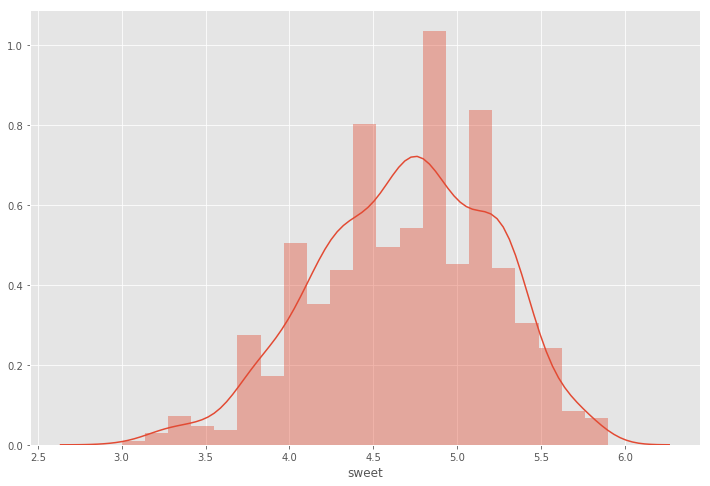

In [708]:
# df_trainvalの前処理を行う
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval['sweet'])

In [709]:
df_trainval.head()

,sweet,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7,quarter_3rd,quarter_4th,sweet_category
680,4.9,6.24,689.22,7.27,59.69,20.39,26.80,17.56,9.24,187.6,122.9,64.7,0,1,3
1528,4.7,7.56,480.53,9.33,58.27,23.35,29.89,13.66,16.23,209.2,95.6,113.6,0,0,3
1552,4.8,7.28,480.53,9.33,58.27,23.35,29.89,13.66,16.23,209.2,95.6,113.6,0,0,3
1607,5.5,4.80,481.18,9.62,60.48,23.74,33.84,19.31,14.53,236.9,135.2,101.7,0,0,4
1979,4.6,6.21,421.50,7.36,67.02,23.02,30.74,17.27,13.47,215.2,120.9,94.3,0,0,3


In [710]:
# sweet_categoryが1のものについて
df_trainval_1 = df_trainval[(df_trainval['sweet_category'] == 1)]

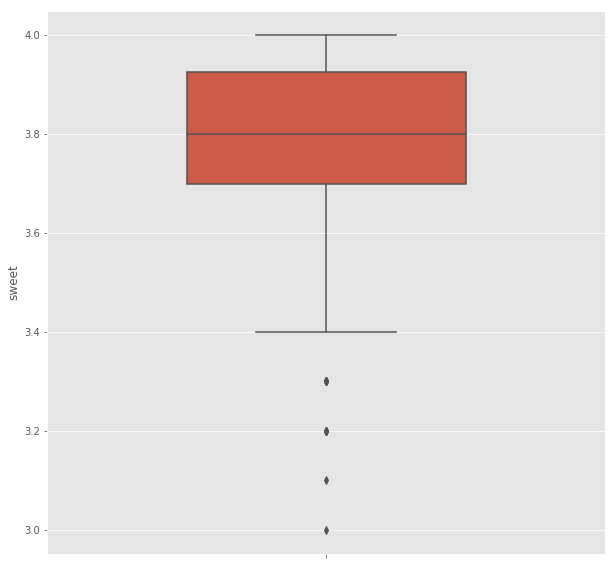

In [711]:
# 箱ひげ図
plt.figure(figsize=(10, 10))
sns.boxplot(df_trainval_1['sweet'], orient='v', width=0.5)

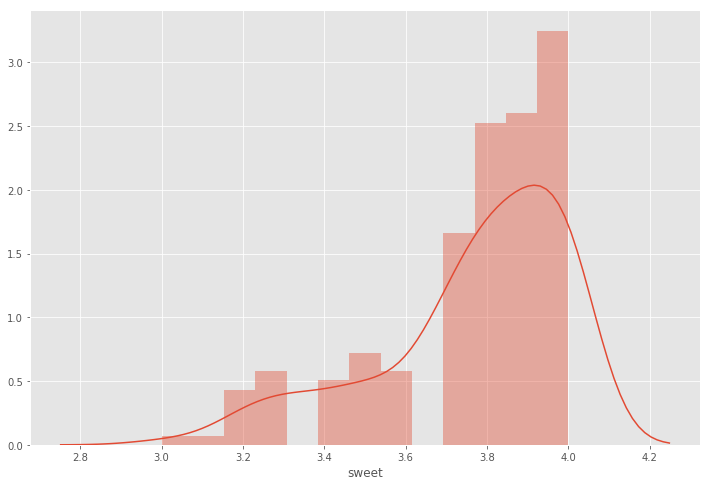

In [712]:
# ヒストグラム
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_1['sweet'])

In [713]:
# 四分位数
def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns
    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        # 四分位範囲
        iqr = q3 - q1
        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5
        # 範囲から外れている値を除く
        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
    return df

In [714]:
# 標準偏差
def outlier_std(df, thresh=3, columns=None):
    if columns == None:
        columns = df.columns
    print(thresh)
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        # 平均値から標準偏差の何倍離れているかを計算
        border = (np.abs(df[col] - mean)) / std # absは絶対値
        # 標準偏差の3倍以上離れているデータを除外
        df = df[(border < 3)]
    return df

In [715]:
print("before", df_trainval_1.shape)
df_trainval_1 = outlier_iqr(df_trainval_1, ['sweet'])
print("after", df_trainval_1.shape)

before (180, 15)
after (164, 15)


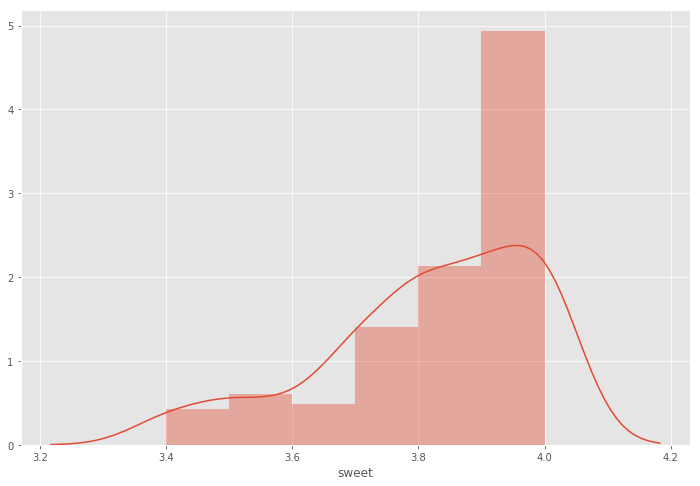

In [716]:
# ヒストグラム
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_1['sweet'])

In [717]:
df_trainval_1['sweet'] = np.log1p(df_trainval_1['sweet'])
df_trainval_1['sweet'].head()

1990    1.526056
153     1.504077
1476    1.609438
1517    1.609438
1357    1.609438
Name: sweet, dtype: float64

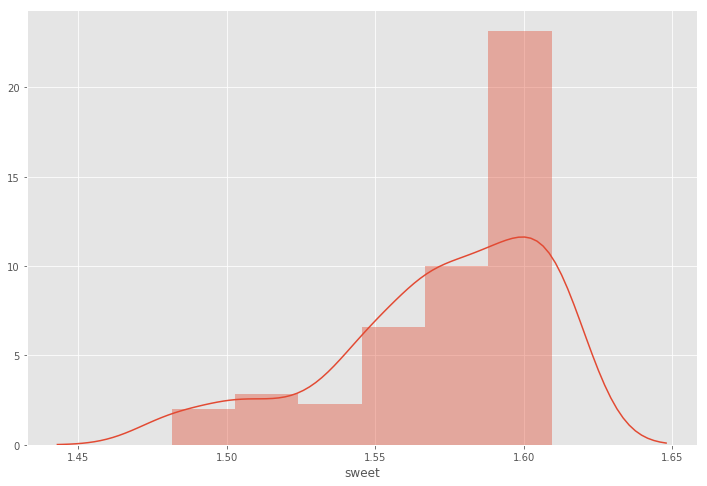

In [718]:
# ヒストグラム
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_1['sweet'])

In [719]:
# sweet_categoryが3のものについて
df_trainval_2 = df_trainval[(df_trainval['sweet_category'] == 2)]

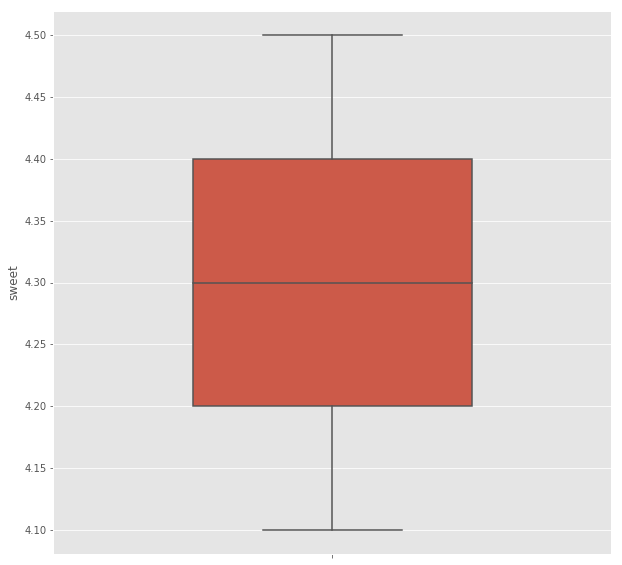

In [720]:
# 箱ひげ図
plt.figure(figsize=(10, 10))
sns.boxplot(df_trainval_2['sweet'], orient='v', width=0.5)

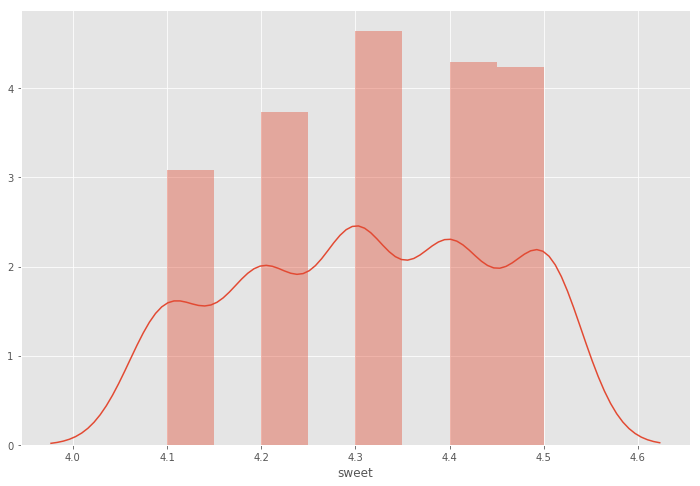

In [721]:
# ヒストグラム
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_2['sweet'])

In [722]:
print("before", df_trainval_2.shape)
df_trainval_2 = outlier_iqr(df_trainval_2, ['sweet'])
print("after", df_trainval_2.shape)

before (396, 15)
after (396, 15)


In [723]:
df_trainval_2['sweet'] = np.log1p(df_trainval_2['sweet'])
df_trainval_2['sweet'].head()

788     1.629241
1637    1.629241
2128    1.667707
538     1.648659
1093    1.686399
Name: sweet, dtype: float64

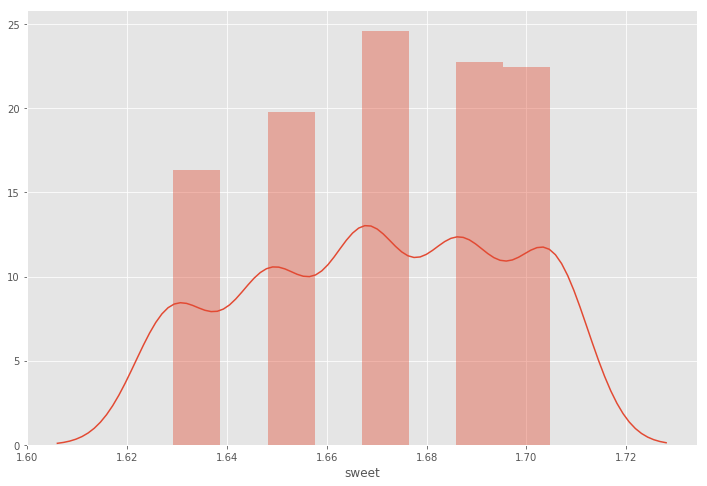

In [724]:
# ヒストグラム
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_2['sweet'])

In [725]:
# sweet_categoryが3のものについて
df_trainval_3 = df_trainval[(df_trainval['sweet_category'] == 3)]

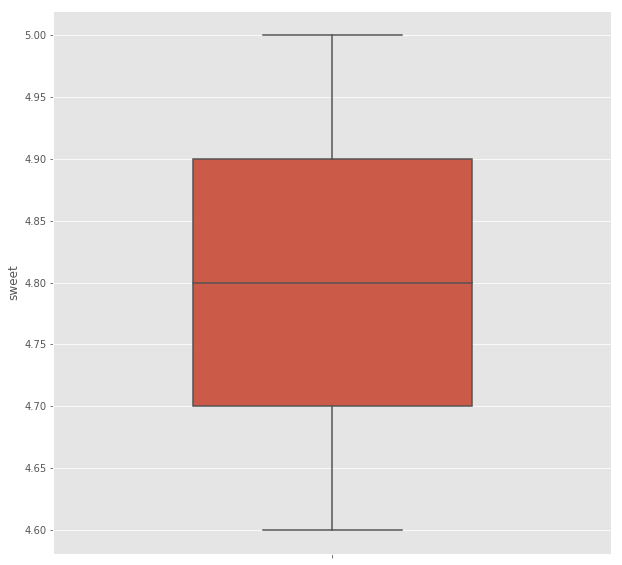

In [726]:
# 箱ひげ図
plt.figure(figsize=(10, 10))
sns.boxplot(df_trainval_3['sweet'], orient='v', width=0.5)

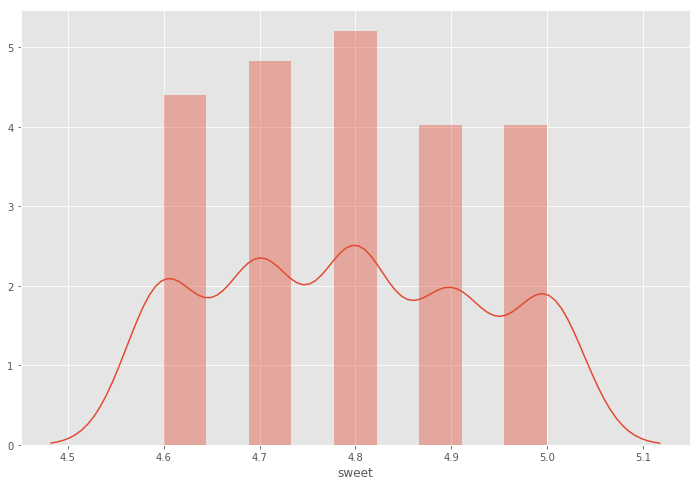

In [727]:
# ヒストグラム
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_3['sweet'])

In [728]:
print("before", df_trainval_3.shape)
df_trainval_3 = outlier_iqr(df_trainval_3, ['sweet'])
print("after", df_trainval_3.shape)

before (531, 15)
after (531, 15)


In [729]:
df_trainval_3['sweet'] = np.log1p(df_trainval_3['sweet'])
df_trainval_3['sweet'].head()

680     1.774952
1528    1.740466
1552    1.757858
1979    1.722767
771     1.791759
Name: sweet, dtype: float64

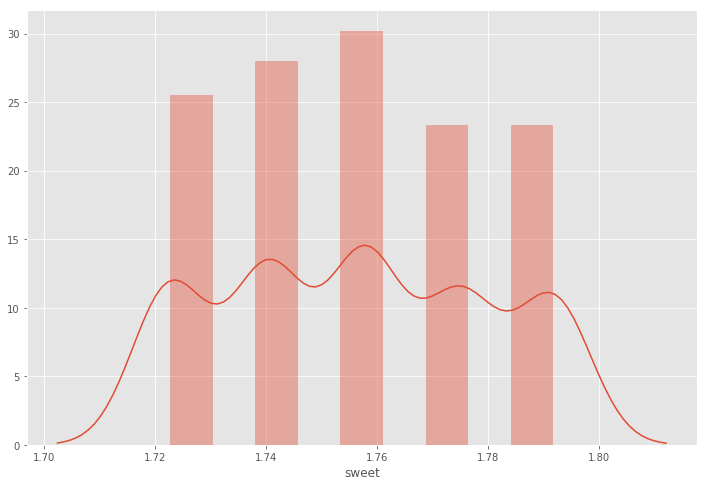

In [730]:
# ヒストグラム
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_3['sweet'])

In [731]:
# sweet_categoryが4のものについて
df_trainval_4 = df_trainval[(df_trainval['sweet_category'] == 4)]

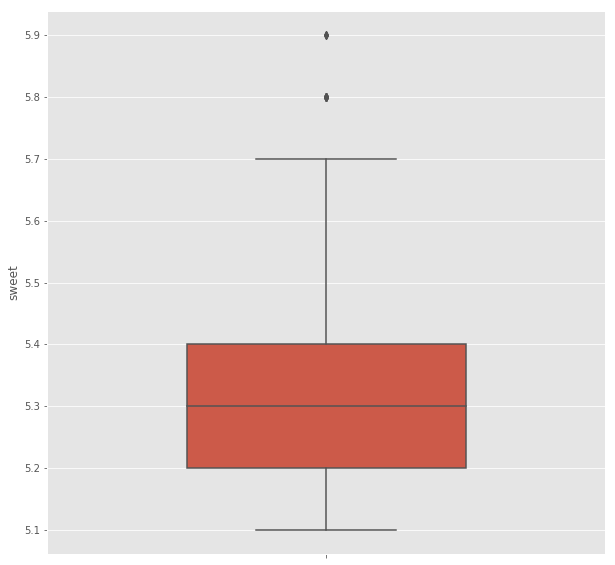

In [732]:
# 箱ひげ図
plt.figure(figsize=(10, 10))
sns.boxplot(df_trainval_4['sweet'], orient='v', width=0.5)

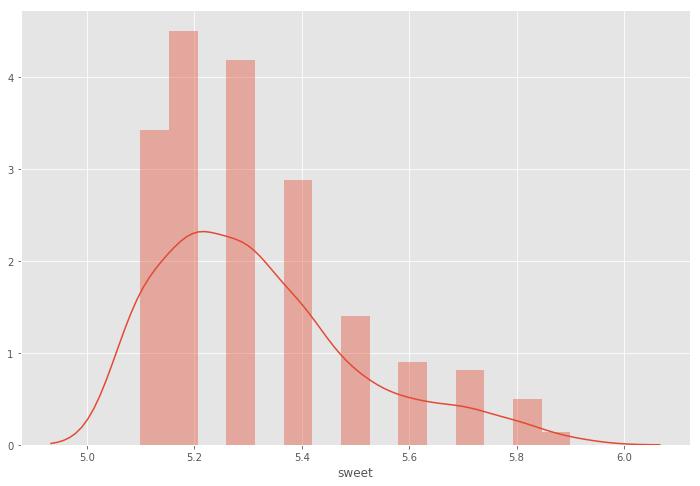

In [733]:
# ヒストグラム
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_4['sweet'])

In [734]:
print("before", df_trainval_4.shape)
df_trainval_4 = outlier_iqr(df_trainval_4, ['sweet'])
print("after", df_trainval_4.shape)

before (416, 15)
after (402, 15)


In [735]:
df_trainval_4['sweet'] = np.log1p(df_trainval_4['sweet'])
df_trainval_4['sweet'].head()

1607    1.871802
518     1.902108
368     1.840550
1287    1.887070
1591    1.824549
Name: sweet, dtype: float64

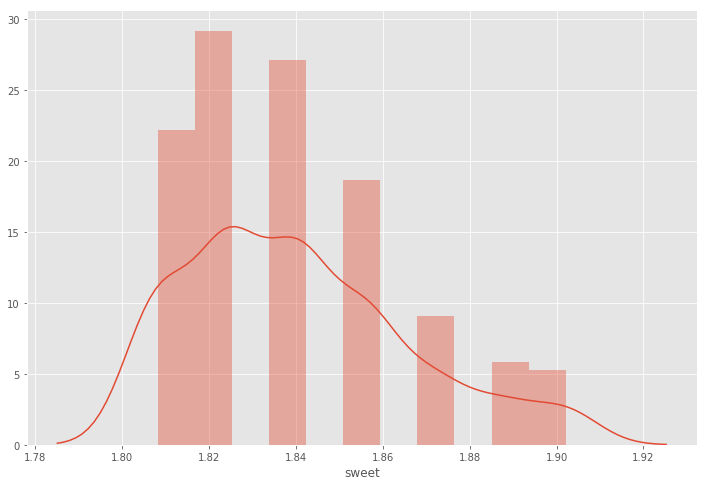

In [736]:
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_4['sweet'])

In [737]:
# 4つのデータフレームを結合
df_trainval_new = pd.concat([df_trainval_1, df_trainval_2, df_trainval_3, df_trainval_4])
# ランダムに並び替える＆indexを再振り
df_trainval_new = df_trainval_new.sample(frac=1).reset_index(drop=True)

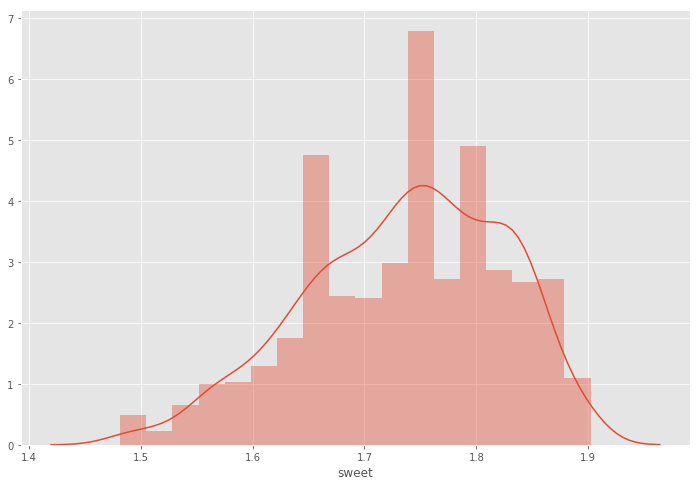

In [738]:
plt.figure(figsize=(12, 8))
sns.distplot(df_trainval_new['sweet'])

In [739]:
y_trainval = df_trainval_new["sweet_category"] #目的変数
df_trainval_new.drop(['sweet','sweet_category'], axis=1, inplace=True) #目的変数の列を削除

In [740]:
df_trainval_new.head()

,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7,quarter_3rd,quarter_4th
0,5.75,509.50,7.43,61.02,21.20,26.34,18.27,8.07,184.4,127.9,56.5,0,1
1,7.02,481.85,7.16,61.83,21.26,25.86,17.66,8.20,181.0,123.6,57.4,0,0
2,4.60,650.12,6.17,65.38,20.48,24.54,18.23,6.31,171.8,127.6,44.2,0,1
3,5.28,542.05,7.38,61.33,21.40,26.60,18.40,8.20,186.2,128.8,57.4,0,0
4,4.83,477.85,8.05,58.34,21.53,26.14,18.21,7.93,183.0,127.5,55.5,0,0


In [741]:
df_trainval_new.drop(['AveCO2_7', 'AveSatu_7', 'AveTemp_7', 'AveMinTemp_7', 'AveDiffTemp_7', 'SumMaxTemp_7', 'SumMinTemp_7', 'SumDiffTemp_7'], axis=1, inplace=True) #対象の列を削除

In [742]:
df_trainval_new.head()

,size,AveHum_7,AveMaxTemp_7,quarter_3rd,quarter_4th
0,5.75,61.02,26.34,0,1
1,7.02,61.83,25.86,0,0
2,4.60,65.38,24.54,0,1
3,5.28,61.33,26.60,0,0
4,4.83,58.34,26.14,0,0


In [743]:
df_trainval_new['size_2'] = df_trainval_new['size']**3
#df_trainval_new['size_3'] = df_trainval_new['size']**3
df_trainval_new['AveHum_7_2'] = df_trainval_new['AveHum_7']**2
df_trainval_new['AveMaxTemp_7_2'] = df_trainval_new['AveMaxTemp_7']**2

In [744]:
df_trainval_new.drop(['size','AveHum_7', 'AveMaxTemp_7'], axis=1, inplace=True) #対象の列を削除

In [745]:
df_trainval_new.head()

,quarter_3rd,quarter_4th,size_2,AveHum_7_2,AveMaxTemp_7_2
0,0,1,190.109375,3723.4404,693.7956
1,0,0,345.948408,3822.9489,668.7396
2,0,1,97.336000,4274.5444,602.2116
3,0,0,147.197952,3761.3689,707.5600
4,0,0,112.678587,3403.5556,683.2996


In [746]:
# ハイパーパラメータを辞書型
params_grid = {'weights': ['uniform', 'distance'], 'n_neighbors':[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]}

In [747]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [748]:
grid_search = GridSearchCV(KNeighborsClassifier(), params_grid, scoring="accuracy",cv=10, n_jobs=-1)# 上記で用意したパラメーターごとに交差検証を実施

In [749]:
grid_search.fit(df_trainval_new, y_trainval) # 学習

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [750]:
# グリッドサーチの結果
print('Best cross-validation: {}'.format(round(grid_search.best_score_, 3)))
print('Best parameters : {}'.format(grid_search.best_params_))

Best cross-validation: 0.749
Best parameters : {'n_neighbors': 5, 'weights': 'uniform'}


In [751]:
X_test.head()

,sweet,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7,quarter_3rd,quarter_4th
567,5.8,4.20,712.07,6.64,62.71,20.37,24.66,17.94,6.71,172.6,125.6,47.0,0,1
1456,5.2,4.84,443.18,8.95,56.66,22.49,27.03,18.87,8.16,189.2,132.1,57.1,0,0
2159,4.4,8.64,400.77,7.73,66.55,22.04,32.10,15.06,17.04,224.7,105.4,119.3,0,0
1135,4.8,6.25,493.00,7.37,59.39,20.61,26.09,17.37,8.71,182.6,121.6,61.0,0,0
1437,4.0,10.15,443.18,8.95,56.66,22.49,27.03,18.87,8.16,189.2,132.1,57.1,0,0


In [752]:
X_test.drop(['AveCO2_7', 'AveSatu_7', 'AveTemp_7', 'AveMinTemp_7', 'AveDiffTemp_7', 'SumMaxTemp_7', 'SumMinTemp_7', 'SumDiffTemp_7'], axis=1, inplace=True) #対象の列を削除

/home/yoshida/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [754]:
X_test.drop(['sweet'], axis=1, inplace=True) #対象の列を削除

In [755]:
X_test.head()

,size,AveHum_7,AveMaxTemp_7,quarter_3rd,quarter_4th
567,4.20,62.71,24.66,0,1
1456,4.84,56.66,27.03,0,0
2159,8.64,66.55,32.10,0,0
1135,6.25,59.39,26.09,0,0
1437,10.15,56.66,27.03,0,0


In [756]:
X_test['size_2'] = X_test['size']**2
#df_test_new['size_3'] = df_test_new['size']**3
X_test['AveHum_7_2'] = X_test['AveHum_7']**2
X_test['AveMaxTemp_7_2'] = X_test['AveMaxTemp_7']**2

/home/yoshida/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/yoshida/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yoshida/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [757]:
X_test.head()

,size,AveHum_7,AveMaxTemp_7,quarter_3rd,quarter_4th,size_2,AveHum_7_2,AveMaxTemp_7_2
567,4.20,62.71,24.66,0,1,17.6400,3932.5441,608.1156
1456,4.84,56.66,27.03,0,0,23.4256,3210.3556,730.6209
2159,8.64,66.55,32.10,0,0,74.6496,4428.9025,1030.4100
1135,6.25,59.39,26.09,0,0,39.0625,3527.1721,680.6881
1437,10.15,56.66,27.03,0,0,103.0225,3210.3556,730.6209


In [758]:
X_test.drop(['size','AveHum_7', 'AveMaxTemp_7'], axis=1, inplace=True) #対象の列を削除

In [759]:
X_test.head()

,quarter_3rd,quarter_4th,size_2,AveHum_7_2,AveMaxTemp_7_2
567,0,1,17.6400,3932.5441,608.1156
1456,0,0,23.4256,3210.3556,730.6209
2159,0,0,74.6496,4428.9025,1030.4100
1135,0,0,39.0625,3527.1721,680.6881
1437,0,0,103.0225,3210.3556,730.6209


In [760]:
print('Test set score : {}'.format(round(grid_search.score(X_test, y_test), 3)))

Test set score : 0.3


In [761]:
# 多クラス混合行列
from sklearn.metrics import confusion_matrix
clf = grid_search.best_estimator_
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))

[[  0   0  23  54]
 [  0   0  28 142]
 [  0   0  18 210]
 [  0   0   0 178]]


In [625]:
# テストデータに対して
df_test = pd.concat([X_test, y_test], axis=1)


df_test_1 = df_test[(df_test['sweet_category'] == 1)]
print("before", df_test_1.shape)
df_test_1 = outlier_iqr(df_test_1, ['sweet'])
print("after", df_test_1.shape)
df_test_1['sweet'] = np.log1p(df_test_1['sweet'])


df_test_2 = df_test[(df_test['sweet_category'] == 2)]
print("before", df_test_2.shape)
df_test_2 = outlier_iqr(df_test_2, ['sweet'])
print("after", df_test_2.shape)
df_test_2['sweet'] = np.log1p(df_test_2['sweet'])


df_test_3 = df_test[(df_test['sweet_category'] == 3)]
print("before", df_test_3.shape)
df_test_3 = outlier_iqr(df_test_3, ['sweet'])
print("after", df_test_3.shape)
df_test_3['sweet'] = np.log1p(df_test_3['sweet'])


df_test_4 = df_test[(df_test['sweet_category'] == 4)]
print("before", df_test_4.shape)
df_test_4 = outlier_iqr(df_test_4, ['sweet'])
print("after", df_test_4.shape)
df_test_4['sweet'] = np.log1p(df_test_4['sweet'])


# 4つのデータフレームを結合
df_test_new = pd.concat([df_test_1, df_test_2, df_test_3, df_test_4])
# ランダムに並び替える＆indexを再振り
df_test_new = df_test_new.sample(frac=1).reset_index(drop=True)


y_test = df_test_new["sweet_category"] #目的変数
df_test_new.drop(['sweet','sweet_category'], axis=1, inplace=True) #目的変数の列を削除


df_test_new.drop(['AveCO2_7', 'AveSatu_7', 'AveTemp_7', 'AveMinTemp_7', 'AveDiffTemp_7', 'SumMaxTemp_7', 'SumMinTemp_7', 'SumDiffTemp_7'], axis=1, inplace=True) #対象の列を削除


df_test_new['size_2'] = df_test_new['size']**2
#df_test_new['size_3'] = df_test_new['size']**3
df_test_new['AveHum_7_2'] = df_test_new['AveHum_7']**2
df_test_new['AveMaxTemp_7_2'] = df_test_new['AveMaxTemp_7']**2

df_test_new.drop(['size','AveHum_7', 'AveMaxTemp_7'], axis=1, inplace=True) #対象の列を削除

before (75, 15)
after (18, 15)
before (170, 15)
after (52, 15)
before (228, 15)
after (75, 15)
before (167, 15)
after (57, 15)


In [626]:
print('Test set score : {}'.format(round(grid_search.score(df_test_new, y_test), 3)))

Test set score : 0.282


In [624]:
# 多クラス混合行列
from sklearn.metrics import confusion_matrix
clf = grid_search.best_estimator_
pred = clf.predict(df_test_new)
print(confusion_matrix(y_test, pred))

[[  0   0  21  54]
 [  0   0  32 138]
 [  0   0  19 209]
 [  0   0   0 167]]
